# Measuring speed from CPU times per event
### Authors: Andrea Sciabà, Andrea Valassi

The goal is to measure the CPU power of sites from the CPU time per event of ATLAS production jobs.

In [1]:
import sys
import math
import csv
from collections import defaultdict, OrderedDict, Counter
import pprint as pp
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from __future__ import division

%matplotlib inline

First, let's read the data from the CSV file.

In [2]:
df = pd.read_csv('task_cpu_hcx.csv', names=['processingtype', 'transformation', 'atlrel', 'site',
                                        'cputype', 'njobs', 'cpuevt_avg', 'cpuevt_rms', 'wallevt_avg',
                                        'wallevt_rms', 'cpu', 'wc', 'cores', 'jevts', 'eff'])

Let's choose jobs of a given processing type by site or cpu.

In [3]:
mode = 'cputype'

Let's store in a dict indexed by the task number and the site or CPU type the averages and standard deviations of the CPU time per event.

In [4]:
grouped = df.groupby([mode], as_index=False, sort=False)

data = OrderedDict()
for (s), g in grouped:
    x = np.average(g.cpuevt_avg, weights=g.cpu)
    y = math.sqrt(np.average((g.cpuevt_avg - x)**2, weights=g.cpu))
    data[s] = (x, y)

Let's map sites or CPU types to integers and store the mapping for later use.

In [5]:
i = -1
sites = set()
smap = dict()
for s in data.keys():
    if s not in sites:
        i += 1
        smap[s] = i
        sites.add(s)
        data[smap[s]]= data[s]
        del data[s]

nsites = len(smap)
print 'There are %s sites in the fit' % nsites

There are 101 sites in the fit


## Second analysis

This analysis uses a much better model and procedure to fit the speeds.

In the following, $\alpha$ indicates an index running over tasks and $i$ and index running over sites or CPU times.
The population average of the CPU time per event for task $\alpha$ at site or CPU $i$ is $\mu_{i\alpha}$ and the average we measure is $a_{i\alpha}$. Of course, not all sites or CPU types appear on all tasks, so sums over $i$ run only on sites or CPU types where the task runs.

It is assumed that the $a_{i\alpha}$ values we measure are Gaussian-distributed around $\mu_{i\alpha}$ with standard deviation $\sigma_{i\alpha}$.

It is also assumed that the speed factors $k_i$ do not depend on $\alpha$, and in particular that $\mu_{i\alpha}k_i=A_\alpha$, where $A_\alpha$ is a constant with respect to $i$.

It is assumed that also $\sigma_{i\alpha}=S_\alpha\mu_{i\alpha},\:\forall i, \alpha$.

To make the analysis easier, we choose to use $\sigma_{i\alpha}$ as errors on $a_{i\alpha}$, while it would be more correct to use $\sigma_{i\alpha}/\sqrt{N_{i\alpha}}$, where $N_{i\alpha}$ is the number of jobs run at site or CPU type $i$ for task $\alpha$ (_approx. #1_).

We also assume that $S_\alpha = S$, where $S$ is constant for all tasks (_approx. #2_).

The $\chi^2$ we want to minimise is the following:

$$\chi^2=\sum_{i\alpha}\left(\frac{a_{i\alpha}-\mu_{i\alpha}}{\sigma_{i\alpha}}\right)^2=\sum_{i\alpha}\left(\frac{a_{i\alpha}-\mu_{i\alpha}}{S_\alpha\mu_{i\alpha}}\right)^2=\sum_\alpha\frac{1}{S_\alpha^2}\sum_i\left(\frac{a_{i\alpha}}{\mu_{i\alpha}}-1\right)^2=\sum_\alpha\frac{1}{S_\alpha^2}\sum_i\left(\frac{a_{i\alpha}k_i}{A_\alpha}-1\right)^2$$

finally, taking into account the approximations above:

$$\boxed{\chi^2=\frac{1}{S^2}\sum_\alpha\frac{1}{A_\alpha^2}\sum_i\left(a_{i\alpha}k_i-A_\alpha\right)^2}$$

As $S$ is a constant, we can minimise a function $f=S^2\chi^2$ and the free parameters are $A_\alpha$ and $k_i$.

To recap, the function to minimise is

$$f=\sum_\alpha\frac{1}{A_\alpha^2}\sum_i\left(a_{i\alpha}k_i-A_\alpha\right)^2$$

its gradient is

$$\begin{align}\frac{\partial f}{\partial A_\alpha}&=-2\sum_i\frac{a_{i\alpha}k_i}{A_\alpha^2}\left(\frac{a_{i\alpha}k_i}{A_\alpha}-1\right)\\\frac{\partial f}{\partial k_i}&=\sum_\alpha\frac{1}{A_\alpha^2}2a_{i\alpha}(a_{i\alpha}k_i-A_\alpha)\end{align}$$

and its Hessian is

$$\begin{align}\frac{\partial^2f}{\partial A_\alpha\partial A_\beta}&=\delta_{\alpha\beta}\times\frac{2}{A_\alpha^4}\sum_i(3a_{i\alpha}^2k_i^2-2a_{i\alpha}k_i A_\alpha)\\
\frac{\partial^2f}{\partial k_i\partial k_j}&=\delta_{ij}\times 2\sum_\alpha\frac{a_{i\alpha}^2}{A_\alpha^2}\\
\frac{\partial^2f}{\partial k_i\partial A_\alpha}&=-2\frac{a_{i\alpha}}{A_\alpha^2}\left(2\frac{a_{i\alpha}k_i}{A_\alpha}-1\right)
\end{align}$$

We use as initial values $k_i=1$ and $A_\alpha=(\sum_i a_{i\alpha})/n_\alpha$, where $n_\alpha$ is the number of sites or CPU types in task $\alpha$.

In [6]:
nsite = len(smap)
a_ini = np.zeros(1)
a_ini[0] = np.mean([b[0] for b in data.values()])
print a_ini[0]
x_ini = np.hstack((a_ini, np.ones(nsite)))

343.408992114


In [7]:
print "Sites/CPUs: ", nsite
print "Sum of initial values: ", np.sum(x_ini)

Sites/CPUs:  101
Sum of initial values:  444.408992114


The function and its derivatives are implemented.

In [8]:
def func_val(x):
    a = x[:1]
    k = x[1:]
    total = 0.
    kf = np.array([k[i] for i in data.keys()])
    v = np.array([b[0] for b in data.values()])
    f_term = 1. / a[0]**2 * (v * kf - a[0])**2
    delta = np.sum(f_term)
    total += delta
    return total

In [9]:
def grad_val(x):
    a = x[:1]
    k = x[1:]
    g = np.zeros(len(x))
    g_a = 0.
    for i in data.keys():
        (v, _) = data[i]
        g_a += -2 * v * k[i] / a[0]**2 * (v * k[i] / a[0] - 1)
        g_k = 2 / a[0]**2 * v * (k[i] * v - a[0])
        g[1 + i] += g_k
    g[0] = g_a
    return g

In [10]:
def hess_val(x):
    a = x[:1]
    k = x[1:]
    diag = np.zeros_like(x)   # diagonal of the Hessian
    H = np.diag(diag)
    h = 0.
    for i in data.keys():
        (v, _) = data[i]
        h += 2 / a[0]**4 * (3 * v**2 * k[i]**2 - 2 * v * k[i] * a[0])
        diag[1 + i] += 2 * v**2 / a[0]**2
        H[0][1+i] = H[1+i][0] = -2 * v / a[0]**2 * ( 2 * v * k[i] / a[0] - 1)
    diag[0] = h
    H = H + np.diag(diag)
    return H

In [11]:
func_val(x_ini)

9.2962701255528408

In [12]:
check = optimize.check_grad(func_val, grad_val, x_ini)
print check

1.0530201041e-06


The minimisation is performed.

In [13]:
result_val = optimize.minimize(func_val, x_ini, method='Newton-CG', jac=grad_val, hess=hess_val, options={'disp': True, 'maxiter': 2000})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 20
         Hessian evaluations: 10


It is worth noting that the problem is underdetermined: multiplying all $k_i$ and all $A_\alpha$ by the same number would not change the value of the function. Hence, the absolute scale of the fitted parameters has no meaning (as expected), and they should be rescaled to an appropriate reference. In principle, the fit should not converge, but it does. A more rigorous approach would be to fix one of the $k_i$ parameters to one and reduce by one the number of parameters fitted. This is left as a future improvement.

The fitted parameters are printed:

In [14]:
k_val = result_val.x[1:]

In [15]:
output_file = 'results_cputype_task_cpu_sub_0_hc.csv'
with open(output_file, 'wb') as csvfile:
    w = csv.writer(csvfile, delimiter=',')
    for s in sorted(smap.keys()):
        print '%s\t%f' % (s, k_val[smap[s]])
        w.writerow([s, k_val[smap[s]]])

Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz 35840 KB	2.163611
s+AMD Opteron(TM) Processor 6212                  2048 KB	0.840385
s+AMD Opteron(TM) Processor 6234                  2048 KB	0.861525
s+AMD Opteron(TM) Processor 6238                  2048 KB	0.811207
s+AMD Opteron(TM) Processor 6272                  2048 KB	0.634158
s+AMD Opteron(TM) Processor 6274                  2048 KB	0.685652
s+AMD Opteron(TM) Processor 6276                  2048 KB	0.723194
s+AMD Opteron(tm) Processor 6134 512 KB	0.962596
s+AMD Opteron(tm) Processor 6168 512 KB	0.787791
s+AMD Opteron(tm) Processor 6174 512 KB	0.901499
s+AMD Opteron(tm) Processor 6176 512 KB	0.877951
s+AMD Opteron(tm) Processor 6320                  2048 KB	1.009234
s+AMD Opteron(tm) Processor 6376                  2048 KB	0.819302
s+Dual-Core AMD Opteron(tm) Processor 2212 HE 1024 KB	0.712893
s+Dual-Core AMD Opteron(tm) Processor 2216 1024 KB	0.849734
s+Dual-Core AMD Opteron(tm) Processor 2218 HE 1024 KB	0.920029
s+Dual-Core AMD Optero

### Error estimation

In order to estimate the error on the fitted parameters, we can use the standard method of finding the variations on the parameters that increase the value of $\chi^2$ by one with respect to its minimum. To do this, we must calculate the value of $S$.

From what was said above:

$$S=\frac{\sigma_{i\alpha}k_i}{A_\alpha}$$

and considering that $\sigma_{i\alpha}$ is the standard deviation of $a_{i\alpha}$, we can expect that the observed values $\frac{a_{i\alpha}k_i}{A_\alpha}$ will be distributed around one with a standard deviation of $S$.

Around the minimum, the following equation holds:

$$1\equiv\chi^2-\chi^2_{\text{min}}=\frac{\Delta f}{S^2}\simeq\frac{1}{S^2}\frac{1}{2}\frac{\partial^2f}{\partial k_i^2}\Delta k_i^2$$

and considering that

$$\frac{\partial^2f}{\partial k_i^2}=2\sum_\alpha\frac{a_{i\alpha}^2}{A_\alpha^2}$$

one concludes that

$$\Delta k_i\simeq\frac{S}{\sqrt{\sum_\alpha\frac{a_{i\alpha}^2}{A_\alpha^2}}}$$

We can easily measure $S$ from the data as follows.

In [22]:
x = result_val.x
points = list()
for i in data.keys():
    (v, _) = data[i]
    p = v * x[1+i] / x[0]
    points.append(p)

The value of S is: 0.000


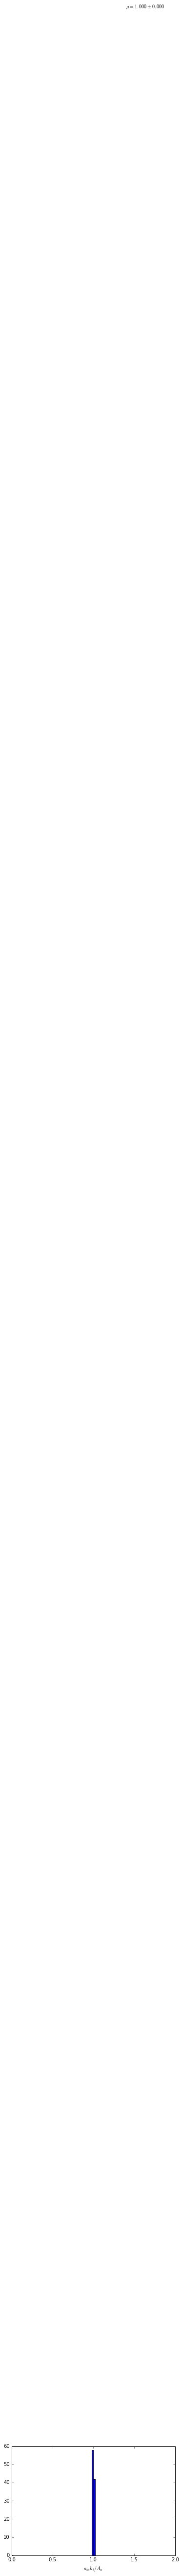

In [23]:
bins = 100
xrange = (0., 2.)
binsize = (xrange[1] - xrange[0]) / bins
fig = plt.hist(points, bins=bins, range=xrange)
n = len(points)
mu = np.mean(points)
sigma = np.std(points)
plt.xlabel(r'$a_{i\alpha}k_i/A_\alpha$')
plt.text(1.4, 1400., r'$\mu=%.3f\pm%.3f$' % (mu, sigma))
S = sigma
print 'The value of S is: %.3f' % S

For fun, let's fit the distribution with one gaussian.

In [24]:
y, x = np.histogram(points, bins=bins, range=xrange)
y = np.divide(y, np.float(np.sum(y))*binsize)

0.988468120827 0.00958170602392
The value of S is: 0.010


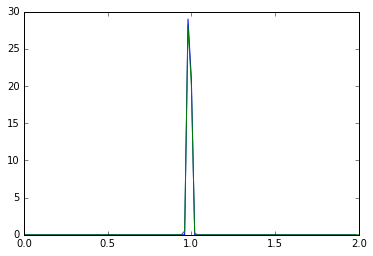

In [25]:
def f(x, m, s):
    return 1 / (s * np.sqrt(2 * np.pi)) * np.exp(-(x - m)**2 / (2 * s**2))

plt.plot(x[:-1], y)
(m, s), _ = optimize.curve_fit(f, x[:-1], y)
print m, s
plt.plot(x, f(x, m, s))
S1 = s
print 'The value of S is: %.3f' % S1

In [26]:
x = result_val.x
points2 = list()
for i in data.keys():
    (v, _) = data[i]
    p = v / a_ini[0]
    points2.append(p)

The value of S is: 0.302


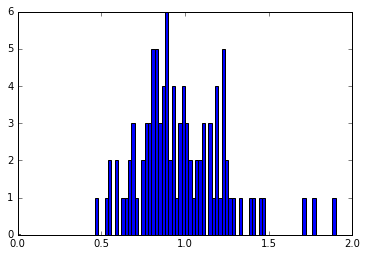

In [27]:
bins = 100
xrange = (0., 2.)
binsize = (xrange[1] - xrange[0]) / bins
fig = plt.hist(points2, bins=bins, range=xrange)
n = len(points2)
mu = np.mean(points2)
sigma = np.std(points2)
print 'The value of S is: %.3f' % sigma
S = sigma

In [28]:
x = result_val.x
a = x[:1]
k = x[1:]
k_err = np.zeros_like(k)
c = 0
c += len(data)
for i in data.keys():
    (v, _) = data[i]
    k_err[i] += v**2 / a[0]**2
k_err = S / np.sqrt(k_err)

### Goodness of fit

To test the goodness of our fit, we can calculate the reduced $\chi^2$ ad the minimum, which is $\chi^2/(N-m)$, where $N$ is the number of independent measurements and $m$ the number of fitted parameters.

In [29]:
deg = c
chi2r = func_val(result_val.x) / S**2 / deg
print 'Degrees of freedom: %d' % deg
print 'The value of the reduced chi2 is: %.3f' % chi2r
print 'Standard deviation of reduced chi2: %.3f' % (1. / np.sqrt(2. * deg))

Degrees of freedom: 100
The value of the reduced chi2 is: 0.000
Standard deviation of reduced chi2: 0.071
